In [30]:
import os
import time
import numpy as np
from numba import cuda
from PIL import Image
import matplotlib.pyplot as plt

### Predefined input
For Gaussian distribution, higher standard deviation (σ) means:<br>
Larger spread, smaller differnces between center and edge weight, more blur

In [31]:
# Gaussian kernel (window filter)
GAUSSIAN_KERNEL = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)

# Normalize the kernel
GAUSSIAN_KERNEL = GAUSSIAN_KERNEL / np.sum(GAUSSIAN_KERNEL)

### Gaussian blur convolution without shared memory

All threads use globale memory (high latency, limited bandwidth)

In [43]:
@cuda.jit
def gaussian_blur_kernel_without_shared(input_img, output_img, width, height):
    # GPU kernel on EACH PIXEL
    # General formula for thread index calculation (thread -> block -> grid)
    tx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    ty = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    
    # Doing boundary check, grid dimensions can be larger than image dimensions
    # We only process pixels within image boundaries
    if tx < width and ty < height:
        # Initialize sum for each channel
        sum_r = 0.0
        sum_g = 0.0
        sum_b = 0.0
        weight_sum = 0.0
        
        # Iterate over the Gaussian kernel
        # For EACH PIXEL, we form a 7x7 neighborhoods surrounding it to 
        # This neighborhood used for convolution => new blur value of THAT PIXEL
        for ky in range(-3, 4):
            for kx in range(-3, 4):
                # Caculate index of neighborhoods
                px = tx + kx
                py = ty + ky
                # Only use pixels in image boundaries (zero padding)
                if 0 <= px < width and 0 <= py < height:
                    # Correspoding kernel weight to the value in 7x7 neighborhood window
                    kernel_value = GAUSSIAN_KERNEL[ky + 3, kx + 3]
                    # Add weighted pixel values
                    sum_r += input_img[py, px, 0] * kernel_value
                    sum_g += input_img[py, px, 1] * kernel_value
                    sum_b += input_img[py, px, 2] * kernel_value
                    # sum(GAUSSIAN_KERNEL)
                    weight_sum += kernel_value
        
        # Normalize and store result, ensure RGB value in range [0,255]
        if weight_sum > 0:
            output_img[ty, tx, 0] = min(max(int(sum_r / weight_sum), 0), 255)
            output_img[ty, tx, 1] = min(max(int(sum_g / weight_sum), 0), 255)
            output_img[ty, tx, 2] = min(max(int(sum_b / weight_sum), 0), 255)

In this example, for one block processing 16x16 pixels:<br>
- Each thread (for a pixel) needs a 7x7 neighborhood to compute new blurred value
- Total area needed is (16+6 x 16+6) = 22x22
- Each thread makes up to 7x7=49 global memory accesses
- Total global memory accesses per (16,16) block: 22x22x49 = 23716

Since pixels' neighborhoods are overlap -> the GPU read same pixel in overlap region from gloabl memory multiple times. More memory accesses = morre power consumption.

Image size: 600x375
Grid size: 38x24
Block size: 16x16
Processing time: 0.0021 seconds


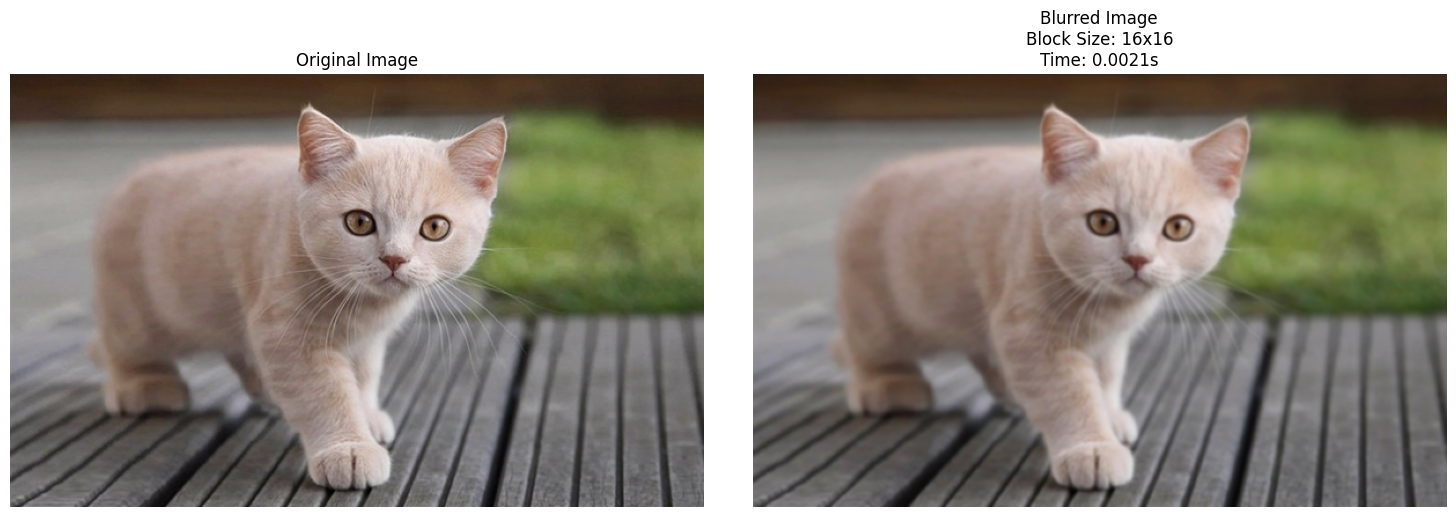

In [42]:
def test_gaussian_blur_without_shared(image_path, block_size=(16, 16)):
    # Load image
    image = np.array(Image.open(image_path))
    height, width = image.shape[:2]
    print(f"Image size: {width}x{height}")

    # Calculate grid dimensions need for image (assing needed threads)
    grid_x = (width + block_size[0] - 1) // block_size[0]
    grid_y = (height + block_size[1] - 1) // block_size[1]
    print(f"Grid size: {grid_x}x{grid_y}")
    print(f"Block size: {block_size[0]}x{block_size[1]}")

    # Step 1: CPU send input and allocate memory for output on GPU
    input_device = cuda.to_device(image)
    output_device = cuda.device_array_like(image)

    # Step 2&3: CPU asign parameter and GPU processing
    start_time = time.time()
    ## Note that kernel need to know grid and block size
    gaussian_blur_kernel_without_shared[(grid_x, grid_y), block_size](
        input_device, output_device, width, height
    )

    # Wait for all kernels in all streams on a CUDA device to complete.
    cuda.synchronize()
    processing_time = time.time() - start_time
    print(f"Processing time: {processing_time:.4f} seconds")

    # Step 4: GPU return result to CPU
    result = output_device.copy_to_host()

    # Visulization
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(result)
    plt.title(f'Blurred Image\nBlock Size: {block_size[0]}x{block_size[1]}\nTime: {processing_time:.4f}s')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

test_gaussian_blur_without_shared("image1.jpg")

### Gaussian blur convolution with shared memory

Each pixel loaded into shared memory, threads accesse pixel's data multiple times from shared memory (faster).<br>
<b>With shared:</b><br>
Only 1 time to read global memory per thread (to obtain shared memory)<br>
49 times read neighborhood memory from shared memory<br>
<br>
<b>Without shared:</b><br>
49 times read neighborhood memory from global memory

In [44]:
@cuda.jit
def gaussian_blur_kernel_with_shared(input_img, output_img, width, height):
    # For 32x32 block size, need 3 pixels on each side for 7x7 kernel(filter window)
    # So we do shared memory for a block of 32 + 3 + 3 = 38 threads
    # Shared memory size should be (BLOCK_DIM_X + 6) * (BLOCK_DIM_Y + 6) * 3
    shared_mem = cuda.shared.array(shape=(38, 38, 3), dtype=np.uint8)  # For 32x32 block size
    
    # Thread indexing for EACH PIXEL
    ## Inside block
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    ## Inside image
    px = cuda.blockIdx.x * cuda.blockDim.x + tx
    py = cuda.blockIdx.y * cuda.blockDim.y + ty
    
    # Calculate local indices for shared memory
    # Pixel position is placing in 32x32 in 38x38 shared memory with padding offset
    local_x = tx + 3 
    local_y = ty + 3
    
    # Load data into shared memory including border pixels
    for dy in range(-3, 4):  # Load 7x7 neighborhood
        y = py + dy
        if 0 <= y < height:
            for dx in range(-3, 4):
                x = px + dx
                if 0 <= x < width:
                    #Matching index in shared mem ~ real index on image ~ index on kernel
                    shared_mem[local_y + dy, local_x + dx, 0] = input_img[y, x, 0]
                    shared_mem[local_y + dy, local_x + dx, 1] = input_img[y, x, 1]
                    shared_mem[local_y + dy, local_x + dx, 2] = input_img[y, x, 2]
                else:
                    shared_mem[local_y + dy, local_x + dx, 0] = 0
                    shared_mem[local_y + dy, local_x + dx, 1] = 0
                    shared_mem[local_y + dy, local_x + dx, 2] = 0
    
    # Ensures all threads finished loading data
    # Required before reading from shared memory
    cuda.syncthreads()
    
    # Process pixels only if within image bounds
    if px < width and py < height:
        sum_r = 0.0
        sum_g = 0.0
        sum_b = 0.0
        weight_sum = 0.0
        
        # Convolve with Gaussian kernel using shared memory
        for ky in range(7):
            for kx in range(7):
                kernel_value = GAUSSIAN_KERNEL[ky, kx]
                sum_r += shared_mem[local_y + ky - 3, local_x + kx - 3, 0] * kernel_value
                sum_g += shared_mem[local_y + ky - 3, local_x + kx - 3, 1] * kernel_value
                sum_b += shared_mem[local_y + ky - 3, local_x + kx - 3, 2] * kernel_value
                weight_sum += kernel_value
        
        # Store result
        if weight_sum > 0:
            output_img[py, px, 0] = min(max(int(sum_r / weight_sum), 0), 255)
            output_img[py, px, 1] = min(max(int(sum_g / weight_sum), 0), 255)
            output_img[py, px, 2] = min(max(int(sum_b / weight_sum), 0), 255)

Image size: 600x375
Grid size: 38x24
Block size: 16x16
Processing time: 0.0010 seconds


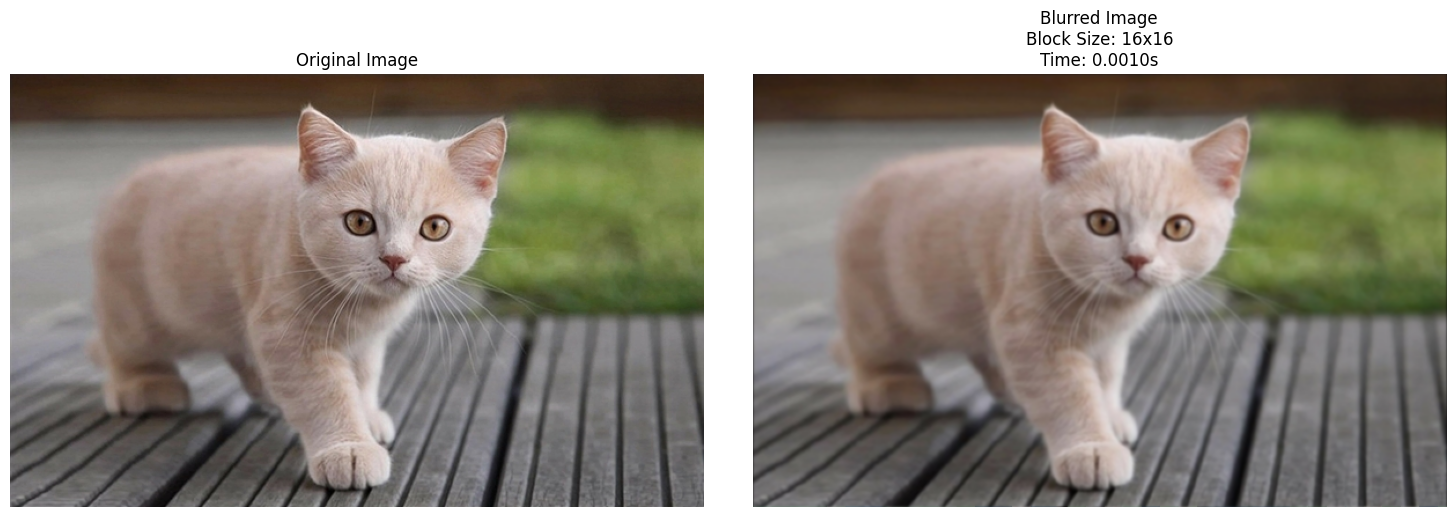

In [46]:
def test_gaussian_blur_with_shared(image_path, block_size=(16, 16)):
    # Load image
    image = np.array(Image.open(image_path))
    height, width = image.shape[:2]
    print(f"Image size: {width}x{height}")

    # Calculate grid dimensions need for image (assing needed threads)
    grid_x = (width + block_size[0] - 1) // block_size[0]
    grid_y = (height + block_size[1] - 1) // block_size[1]
    print(f"Grid size: {grid_x}x{grid_y}")
    print(f"Block size: {block_size[0]}x{block_size[1]}")

    # Step 1: CPU send input and allocate memory for output on GPU
    input_device = cuda.to_device(image)
    output_device = cuda.device_array_like(image)

    # Step 2&3: CPU asign parameter and GPU processing
    start_time = time.time()
    ## Note that kernel need to know grid and block size
    gaussian_blur_kernel_with_shared[(grid_x, grid_y), block_size](
        input_device, output_device, width, height
    )

    # Wait for all kernels in all streams on a CUDA device to complete.
    cuda.synchronize()
    processing_time = time.time() - start_time
    print(f"Processing time: {processing_time:.4f} seconds")

    # Step 4: GPU return result to CPU
    result = output_device.copy_to_host()

    # Visulization
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(result)
    plt.title(f'Blurred Image\nBlock Size: {block_size[0]}x{block_size[1]}\nTime: {processing_time:.4f}s')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

test_gaussian_blur_with_shared("image1.jpg")

### Run program and do benchmarking

In [19]:
def process_image(image_path, block_size_x, block_size_y, use_shared_memory=False):
    # Load and prepare image
    image = np.array(Image.open(image_path))
    height, width = image.shape[:2]
    
    # Calculate grid dimensions
    grid_x = (width + block_size_x - 1) // block_size_x
    grid_y = (height + block_size_y - 1) // block_size_y
    
    # Prepare device arrays
    input_device = cuda.to_device(image)
    output_device = cuda.device_array_like(image)
    
    # Process image
    if use_shared_memory:
        gaussian_blur_kernel_with_shared[(grid_x, grid_y), (block_size_x, block_size_y)](
            input_device, output_device, width, height)
    else:
        gaussian_blur_kernel_without_shared[(grid_x, grid_y), (block_size_x, block_size_y)](
            input_device, output_device, width, height)
    cuda.synchronize()
    
    # Get result back from device
    result = output_device.copy_to_host()
    
    return result

def benchmark_kernel(image_path, block_sizes):
    times_without_shared = []
    times_with_shared = []
    
    # Create a figure with subplots for each block size
    num_sizes = len(block_sizes)
    fig, axes = plt.subplots(num_sizes, 3, figsize=(15, 5*num_sizes))
    fig.suptitle('Gaussian Blur Results Comparison', fontsize=16)
    
    # Read original image
    original_img = np.array(Image.open(image_path))
    
    for idx, (block_x, block_y) in enumerate(block_sizes):
        print(f"\nTesting block size: ({block_x}, {block_y})")
        
        # Without shared memory
        start_time = time.time()
        result_normal = process_image(image_path, block_x, block_y, False)
        time_normal = time.time() - start_time
        times_without_shared.append(time_normal)
        print(f"Time without shared memory: {time_normal:.4f} seconds")
        
        # With shared memory
        start_time = time.time()
        result_shared = process_image(image_path, block_x, block_y, True)
        time_shared = time.time() - start_time
        times_with_shared.append(time_shared)
        print(f"Time with shared memory: {time_shared:.4f} seconds")
        
        # Plot results
        if num_sizes == 1:
            ax_row = axes
        else:
            ax_row = axes[idx]
            
        # Original image
        ax_row[0].imshow(original_img)
        ax_row[0].set_title('Original Image')
        ax_row[0].axis('off')
        
        # Without shared memory result
        ax_row[1].imshow(result_normal)
        ax_row[1].set_title(f'Without Shared Memory\nBlock Size: {block_x}x{block_y}\nTime: {time_normal:.4f}s')
        ax_row[1].axis('off')
        
        # With shared memory result
        ax_row[2].imshow(result_shared)
        ax_row[2].set_title(f'With Shared Memory\nBlock Size: {block_x}x{block_y}\nTime: {time_shared:.4f}s')
        ax_row[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return times_without_shared, times_with_shared

def plot_performance_comparison(block_sizes, times_without_shared, times_with_shared):
    plt.figure(figsize=(10, 6))
    x = range(len(block_sizes))
    
    # Calculate speedup
    speedup = [t1/t2 for t1, t2 in zip(times_without_shared, times_with_shared)]
    
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot execution times
    ax1.plot(x, times_without_shared, 'b-o', label='Without Shared Memory')
    ax1.plot(x, times_with_shared, 'r-o', label='With Shared Memory')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'{bx}x{by}' for bx, by in block_sizes])
    ax1.set_xlabel('Block Size')
    ax1.set_ylabel('Processing Time (seconds)')
    ax1.set_title('Execution Time Comparison')
    ax1.legend()
    ax1.grid(True)
    
    # Plot speedup
    ax2.plot(x, speedup, 'g-o', label='Speedup')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{bx}x{by}' for bx, by in block_sizes])
    ax2.set_xlabel('Block Size')
    ax2.set_ylabel('Speedup (times faster)')
    ax2.set_title('Speedup with Shared Memory')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


Testing block size: (8, 8)
Time without shared memory: 0.1261 seconds
Time with shared memory: 0.0033 seconds

Testing block size: (16, 16)
Time without shared memory: 0.0029 seconds
Time with shared memory: 0.0027 seconds

Testing block size: (32, 32)
Time without shared memory: 0.0030 seconds
Time with shared memory: 0.0029 seconds


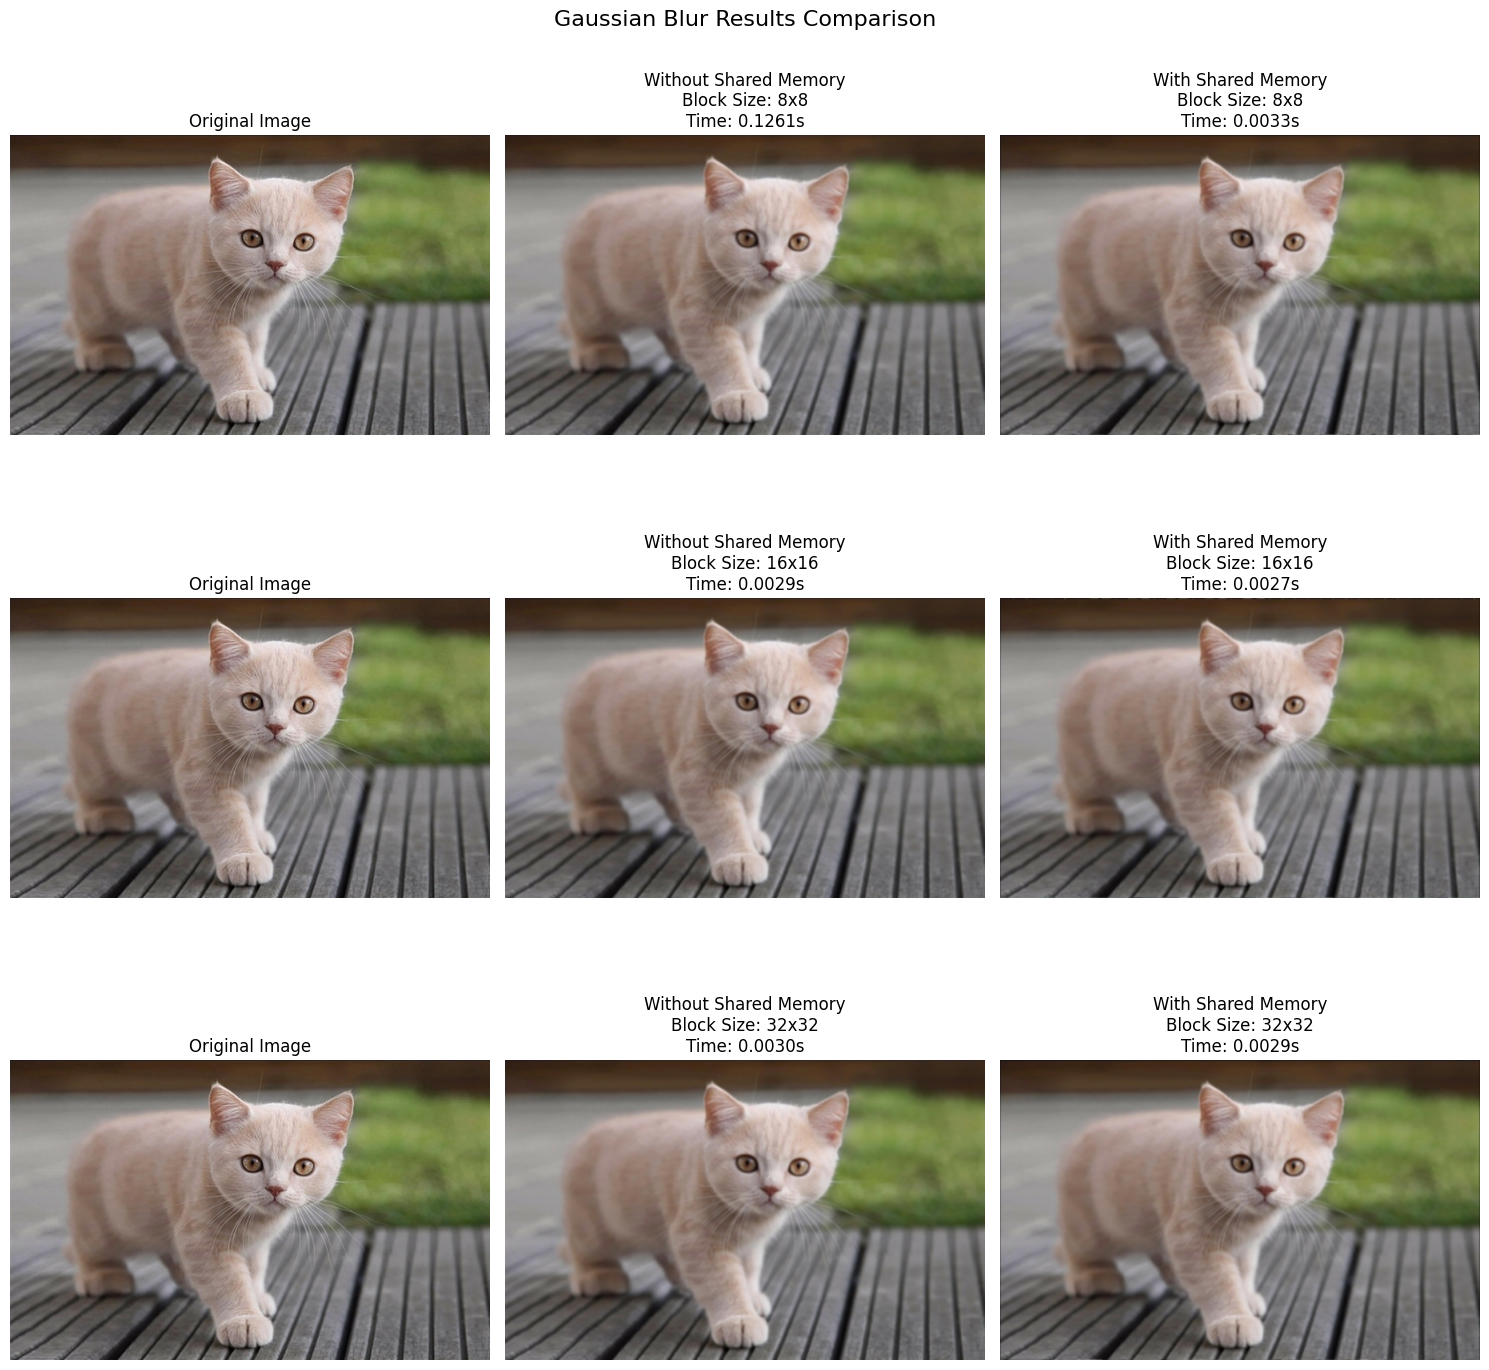

<Figure size 1000x600 with 0 Axes>

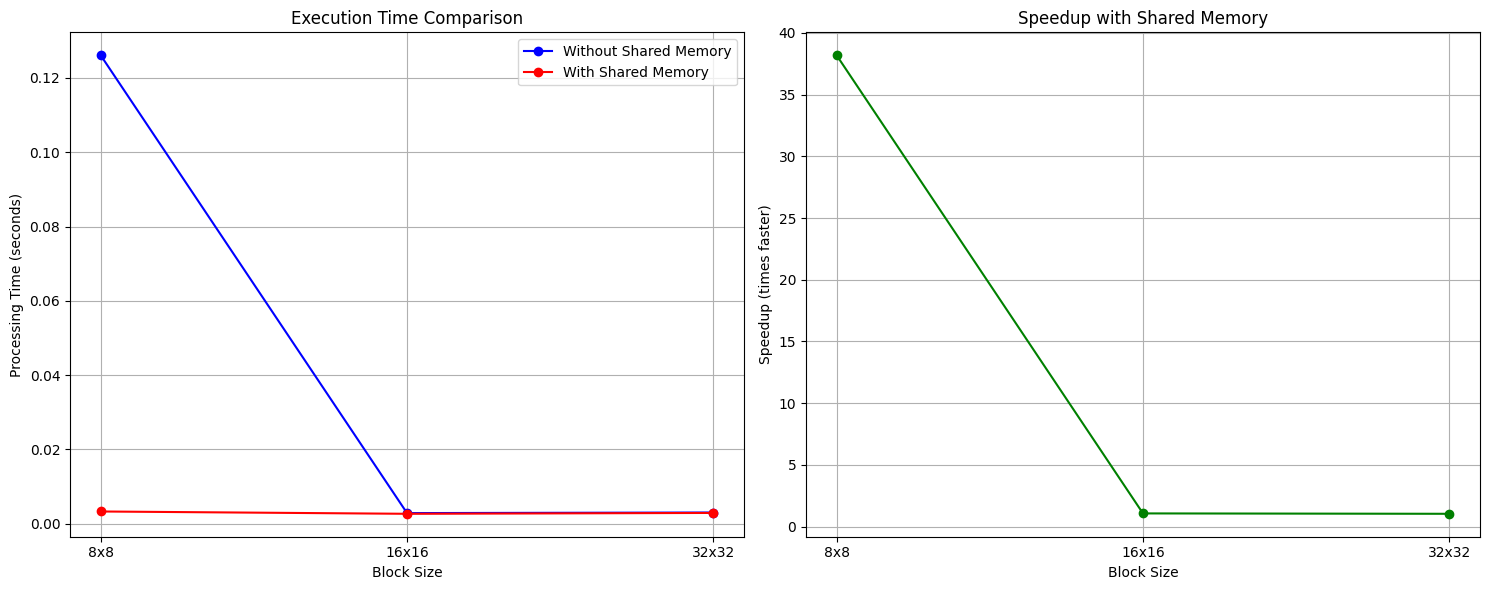

In [47]:
if __name__ == "__main__":
    image_path = "image1.jpg" 

    # Note that block size must < shared memory block
    block_sizes = [(8, 8), (16, 16), (32,32)]
    
    # Run benchmark and display images
    times_without_shared, times_with_shared = benchmark_kernel(image_path, block_sizes)
    
    # Plot performance comparison
    plot_performance_comparison(block_sizes, times_without_shared, times_with_shared)